In [1]:
import sys

sys.path.append('/home/lumargot/hysterectomy-coach/src/py')

In [2]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import torch
import pytorch_lightning as pl
from torchvision import transforms
import cv2
import imageio
import random
import matplotlib.pyplot as plt
from torch.utils.data import Sampler
from torch.utils.data.distributed import DistributedSampler
import monai
import math
from monai.data.utils import pad_list_data_collate
from tqdm import tqdm

from sklearn.metrics import precision_recall_curve, auc

from torchvision.ops import nms

import SimpleITK as sitk

/home/lumargot/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_train = pd.read_csv('/MEDUSA_STOR/jprieto/surgery_tracking/csv/dataset_6_classes_train_train.csv')
df_val = pd.read_csv('/MEDUSA_STOR/jprieto/surgery_tracking/csv/dataset_6_classes_train_test.csv')
df_test = pd.read_csv('/MEDUSA_STOR/jprieto/surgery_tracking/csv/dataset_6_classes_test.csv')

In [4]:
df_train[['Instrument Name', 'class']].value_counts()

Instrument Name             class
Robot Needle Driver         5        25717
Needle                      4        23314
Robot Grasper               6        21491
Vessel Sealer               1         5066
Bipolar                     1         3836
Laparoscopic Grasper        2         3789
Laparoscopic Needle Driver  3         2594
Robot Grasper Heat          1          359
Laparoscopic Suction        1           46
dtype: int64

In [5]:
from nets.segmentation import MaskRCNN
from loaders.hyst_dataset import HystDataModuleSeg, TrainTransformsSeg, EvalTransformsSeg

In [6]:
img_column = 'img_path'
seg_column = 'seg_path'
class_column = 'class'
mount_point = '/MEDUSA_STOR/jprieto/surgery_tracking/'
# ckp = os.path.join(mount_point, 'output/test-model', 'epoch=5-val_loss=0.34.ckpt')
ckpt = '/MEDUSA_STOR/jprieto/surgery_tracking/output/test-6class-cat/epoch=22-val_loss=0.73.ckpt'

In [7]:
num_classes = len(df_train[class_column].unique()) + 1 # background

g_train = df_train.groupby(class_column)
df_train = g_train.apply(lambda x: x.sample(g_train.size().min())).reset_index(drop=True).sample(frac=1).reset_index(drop=True)

g_val = df_val.groupby(class_column)
df_val = g_val.apply(lambda x: x.sample(g_val.size().min())).reset_index(drop=True).sample(frac=1).reset_index(drop=True)


In [8]:
df_train['class'].unique()

array([3, 2, 1, 5, 4, 6])

In [9]:
ttdata = HystDataModuleSeg( df_train, df_val, df_test, batch_size=1, num_workers=4, 
                            img_column=img_column,seg_column=seg_column, class_column=class_column, 
                            mount_point=mount_point,train_transform=TrainTransformsSeg(),valid_transform=EvalTransformsSeg())

ttdata.setup()

test_dl = ttdata.test_dataloader()
test_ds = ttdata.test_ds


In [10]:
def filter_by_confidence(class_ids, scores, masks, boxes, thr):
  """
    Filter detections based on absolute and relative confidence scores. see Notion for example.
    If there are 3 masks with the same labeled, remove the one(s) with lower confidence score(s)

    Args:
        class_ids, scores, masks
        
    Returns:
        Filtered class_ids, scores, and masks
  """

  keep = scores >= thr
  
  class_ids = class_ids[keep]
  scores = scores[keep]
  boxes = boxes[keep]
  masks = masks[keep]
  
  final_keep = []
  unique_classes = np.unique(class_ids)
  
  for class_id in unique_classes:
      class_mask = class_ids == class_id
      if not np.any(class_mask):
          continue
          
      class_scores = scores[class_mask]
      max_score = np.max(class_scores)
      relative_keep = class_scores >= (max_score - (max_score * 0.15))
      
      # Get indices of detections to keep for this class
      keep_idx = np.where(class_mask)[0][relative_keep]
      final_keep.extend(keep_idx)
      
  final_keep = np.array(sorted(final_keep))
    
  return class_ids[final_keep], scores[final_keep], masks[final_keep], boxes[final_keep]

In [11]:
scores = np.array([0.2, 0.4, 0.4])

In [12]:
scores

array([0.2, 0.4, 0.4])

In [13]:
keep = scores >= 0.4

In [14]:
if keep.any():
  print(keep)

[False  True  True]


In [15]:
model = MaskRCNN.load_from_checkpoint(ckpt)
    
model.eval()
model.cuda()

MaskRCNN(
  (model): MaskRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): 

In [16]:
batch = test_ds[0]
imgs, targets = [],[]
img = batch.pop('img', None)

batch['boxes'] = ttdata.compute_bb_mask(batch['masks'], pad=0.01)


batch['boxes'] = batch['boxes'].cuda()
batch['masks'] = batch['masks'].cuda()
batch['labels'] = batch['labels'].cuda()

imgs.append(img.unsqueeze(0))
targets.append(batch)
imgs = torch.cat(imgs)

In [17]:
outputs = model.forward(imgs.cuda(), mode='test')
SCORE_THR = 0.3

boxes = outputs[0]['boxes'].cpu().detach().numpy()
masks = outputs[0]['masks'].cpu().detach().numpy()
labels = outputs[0]['labels'].cpu().detach().numpy()
scores = outputs[0]['scores'].cpu().detach().numpy()

refined_labels, refined_scores, refined_masks, refined_boxes = filter_by_confidence(labels, scores, masks, boxes, thr=0.2)

In [18]:
refined_labels.shape, refined_boxes

((5,),
 array([[ 80.21331 ,  52.363625, 456.17914 , 363.25797 ],
        [414.0969  ,  89.257935, 610.5239  , 252.29065 ],
        [389.21002 ,  11.502008, 567.1714  , 262.10034 ],
        [508.84268 , 278.28134 , 662.8468  , 412.4779  ],
        [122.240814, 154.31522 , 388.64825 , 387.79544 ]], dtype=float32))

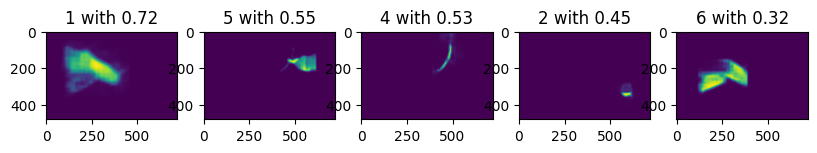

In [19]:
j=1
plt.figure(figsize=(20,10))
for i in range(len(refined_labels)):
  plt.subplot(4,10, j)
  plt.imshow(refined_masks[i,0])
  l, s = refined_labels[i].item(), refined_scores[i]
  plt.title(f"{l} with {s:.2f}")
  j+=1


In [20]:
# seg_stack = []

# for out in outputs:
#   boxes = out['boxes'].cpu().detach()
#   labels =  out['labels'].cpu().detach()
#   scores = out['scores'].cpu().detach()
#   masks = out['masks'].cpu().detach()

#   seg_mask = torch.zeros_like(masks[0,0]) 
#   for i in range(len(labels)):
#     if scores[i] > SCORE_THR:
#       seg_mask[ masks[i,0]> 0.2 ] = labels[i]

#   seg_stack.append(seg_mask.unsqueeze(0))
# seg_stack = torch.cat(seg_stack)

prediction
38


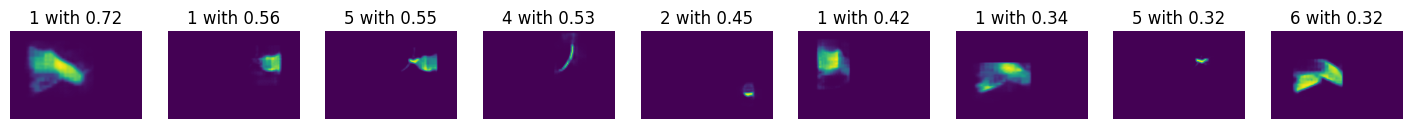

Ground Truth


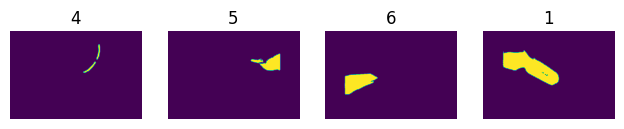

In [21]:
print("prediction")
plt.figure(figsize=(20,8))

print(outputs[0]['labels'].shape[0])
for i in range(outputs[0]['labels'].shape[0]):
  if outputs[0]['scores'][i] > SCORE_THR:
    plt.subplot(4,10, i+1)
    plt.imshow(outputs[0]['masks'][i][0].cpu().detach().numpy())
    l, s = outputs[0]['labels'][i].item(), outputs[0]['scores'][i]
    plt.title(f"{l} with {s:.2f}")
    plt.axis('off')

plt.show()

print("Ground Truth")

gt_seg_mask = torch.zeros_like(batch['masks'])
plt.figure(figsize=(20,8))
for i in range(batch['masks'].shape[0]):
  gt_seg_mask[i, batch['masks'][i] >0.0 ] = batch['labels'][i].float()
  plt.subplot(4,10, i+1)
  plt.imshow(gt_seg_mask[i].cpu().detach().numpy())
  plt.title(batch['labels'][i].item())
  plt.axis('off')


Text(0.5, 1.0, 'ground truth')

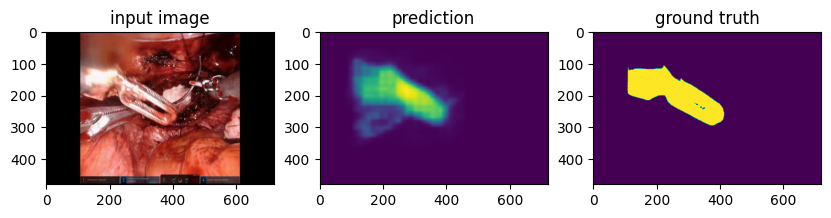

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(imgs[0].permute(1,2,0))
plt.title('input image')
plt.subplot(132)
plt.imshow(outputs[0]['masks'][0][0].cpu().detach().numpy())
plt.title('prediction')
plt.subplot(133)
plt.imshow(gt_seg_mask[3].cpu().detach().numpy())
plt.title('ground truth')

# Evaluation of model performance's 

We should evaluate A) mask prediction B) box regression C) classification

In [23]:
IOU_THR = 0.6## thr for all mAP

1. Compute Intersection over Union (IoU):

2. Evaluate metrics at multiple IoU thresholds:
Calculate precision and recall at various confidence thresholds.

3. Compute Average Precision (AP):
Integrate precision-recall curves for the desired IoU thresholds.

In [24]:
""" 1. Intersection over Union (IoU) """
def compute_mask_iou(gt_mask, pred_mask) :
    """
    Compute IoU between two masks.
    """
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    if union == 0 :
      return 0
    else:
      return intersection / union

def compute_bbx_iou(gt_box, pred_box):
    """
    Compute IoU for two bounding boxes.
    Each box should be [x1, y1, x2, y2]
    """
    x1 = max(gt_box[0], pred_box[0])
    y1 = max(gt_box[1], pred_box[1])
  
    x2 = min(gt_box[2], pred_box[2])
    y2 = min(gt_box[3], pred_box[3])

    interArea = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    gt_boxArea = (gt_box[2] - gt_box[0] + 1) * (gt_box[3] - gt_box[1] + 1)
    pred_boxArea = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)
    iou = interArea / float(gt_boxArea + pred_boxArea - interArea)
    return iou


In [82]:
""" 2. Evaluate metrics at multiple IoU thresholds:
    precision and recall at various confidence thresholds.
"""

def compute_ap_at_iou(dic_gt, dic_pred, iou_threshold):
    """Compute AP for a single IoU threshold."""

    matched = set()
    pred_boxes = dic_pred['cls_pred_boxes']
    pred_masks = dic_pred['cls_pred_masks']
    pred_scores = dic_pred['cls_pred_scores']

    gt_boxes = dic_gt['cls_gt_boxes']
    gt_masks = dic_gt['cls_gt_masks']

    # tp = np.zeros((len(pred_boxes),2))
    # fp = np.zeros((len(pred_boxes),2))

    tp_m, tp_bb = np.zeros(len(pred_boxes)),np.zeros(len(pred_boxes))
    fp_m, fp_bb = np.zeros(len(pred_boxes)),np.zeros(len(pred_boxes))
    
    indices = np.arange(len(pred_boxes))
    for i, pred_box, pred_mask in zip(indices, pred_boxes, pred_masks):
        if pred_scores[i] < 0.0:  # Skip invalid detections
            fp_bb[i] = 1
            fp_m[i] = 1
            continue
        
        ## box
        best_iou_box = 0.0
        best_match_box = -1
        for j, gt_box in enumerate(gt_boxes):
            if j in matched:
                continue
            iou = compute_bbx_iou(gt_box, pred_box)
            if iou > best_iou_box:
                best_iou_box = iou
                best_match_box = j

        if best_iou_box >= iou_threshold:
            tp_bb[i] = 1
            matched.add(best_match_box)            
        else:
            fp_bb[i] = 1

        ## mask
        best_iou_mask = 0.0
        best_match_mask = -1
        for j, gt_mask in enumerate(gt_masks):
            if j in matched:
                continue
            iou = compute_mask_iou(gt_mask, pred_mask)
            if iou > best_iou_mask:
                best_iou_mask = iou
                best_match_mask = j

        if best_iou_box >= iou_threshold:
            tp_m[i] = 1
            matched.add(best_match_mask)            
        else:
            fp_m[i] = 1

    # print(tp, fp)
    # print(tp.shape, fp.shape)

    tp_cumsum_bb = np.cumsum(tp_bb)
    fp_cumsum_bb = np.cumsum(fp_bb)
    
    tp_cumsum_m = np.cumsum(tp_m)
    fp_cumsum_m = np.cumsum(fp_m)

    print(tp_cumsum_bb.shape, tp_cumsum_m.shape)
    p_bb = tp_cumsum_bb / (tp_cumsum_bb + fp_cumsum_bb + 1e-6)
    r_bb = tp_cumsum_bb / len(gt_boxes)

    p_m = tp_cumsum_bb / (tp_cumsum_bb + fp_cumsum_bb + 1e-6)
    r_m = tp_cumsum_bb / len(gt_boxes)


    if len(r_bb) < 2 or len(p_bb) < 2:
        return 0.0, 0.0  # Default AP value if AUC cannot be computed

    print(auc(r_bb, p_bb))
    print(auc(r_m, p_m))

    return auc(r_bb, p_bb), auc(r_m, p_m)

In [80]:
""" 3. Compute Average Precision (AP):
    Integrate precision-recall curves for the desired IoU thresholds
"""


def compute_map_one_class(gt_boxes, pred_boxes, pred_scores, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    """Compute mAP averaged over multiple IoU thresholds."""
    aps = []
    for iou_threshold in iou_thresholds:
        ap = compute_bbx_ap_at_iou(gt_boxes, pred_boxes, pred_scores, iou_threshold)
        aps.append(ap)
    return np.mean(aps), aps


def compute_map_multiclass(ground_truths, predictions, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    """
    Compute mAP for multiclass detection.
    
    Parameters:
        predictions: List of dicts. Each dict contains 'masks', 'boxes', 'scores', 'labels' for predictions.
        ground_truths: List of dicts. Each dict contains 'masks', 'boxes', 'labels' for ground truth.
        iou_thresholds: List of IoU thresholds.
    
    Returns:
        mAP: Mean Average Precision across all classes and IoU thresholds.
        class_aps: AP per class.
    """
    all_classes = set()
    for gt in ground_truths:
        for label in gt['labels']:
            all_classes.add(label)

    class_aps_mask = {}
    class_aps_box = {}

    for cls in all_classes:
        cls_pred_boxes = []
        cls_pred_scores = []
        cls_pred_masks = []

        cls_gt_boxes = []
        cls_gt_masks = []

        # Collect predictions and ground truths for the current class
        for pred, gt in zip(predictions, ground_truths):

            # print((pred), gt) # dict, dict 
            for box, label, score, mask, in zip(pred['boxes'], pred['labels'], pred['scores'], pred['masks']):
                if label == cls:
                    cls_pred_boxes.append(box)
                    cls_pred_masks.append(mask)
                    cls_pred_scores.append(score)

            for box, label, mask in zip(gt['boxes'], gt['labels'], gt['masks']):
                if label == cls:
                    cls_gt_boxes.append(box)
                    cls_gt_masks.append(mask)


        dic_cls_gt = {'cls_gt_masks':cls_gt_masks, 'cls_gt_boxes':cls_gt_boxes}
        dic_cls_pred = {'cls_pred_masks':cls_pred_masks, 'cls_pred_boxes':cls_pred_boxes, 'cls_pred_scores':cls_pred_scores}

        if len(cls_gt_boxes) == 0:
            continue  # Skip classes without ground truths

        box_aps, mask_aps = [],[]
        for iou_threshold in iou_thresholds:
            bb_ap, m_ap = compute_ap_at_iou(dic_cls_gt, dic_cls_pred, iou_threshold)
            print(bb_ap, m_ap)
            box_aps.append(bb_ap)
            mask_aps.append(m_ap)

        class_aps_box[cls] = np.mean(box_aps)
        class_aps_mask[cls] = np.mean(mask_aps)

    box_mAP = np.mean(list(class_aps_box.values()))
    mask_mAP = np.mean(list(class_aps_mask.values()))

    mAP = {"mask": mask_mAP, "box":box_mAP}
    class_aps =  {"mask": class_aps_mask, "box":class_aps_box}

    return mAP, class_aps

In [28]:
gt_masks= gt_seg_mask.cpu().detach().numpy()
pred_masks= outputs[0]['masks'][:,0].cpu().detach().numpy()

gt_boxes = batch['boxes'].cpu().detach().numpy()
pred_boxes = outputs[0]['boxes'].cpu().detach().numpy()
pred_scores = outputs[0]['scores'].cpu().detach().numpy()

In [84]:
all_predictions, all_ground_truths = [], []
batch_size=4
with torch.no_grad():
    for idx, batch in tqdm(enumerate(test_dl), total=len(test_dl)): 
        
        imgs = []
        img = batch.pop('img', None)

        imgs.append(img)
        imgs = torch.cat(imgs)

        outputs = model.forward(imgs.cuda(), mode='test')
        SCORE_THR = 0.4
        # for j in range(batch_size):

        pred_boxes = outputs[0]['boxes'].cpu().detach().numpy()
        pred_masks = outputs[0]['masks'].cpu().detach().numpy()
        pred_labels = outputs[0]['labels'].cpu().detach().numpy()
        pred_scores = outputs[0]['scores'].cpu().detach().numpy()

        gt_masks = batch['masks'][0]
        gt_boxes = ttdata.compute_bb_mask(gt_masks, pad=0.01).numpy()
        gt_labels = batch['labels'][0].cpu().detach().numpy()


        if (pred_scores >=SCORE_THR).any():
            refined_labels, refined_scores, refined_masks, refined_boxes = filter_by_confidence(pred_labels, pred_scores, pred_masks, pred_boxes, thr=SCORE_THR)
            all_predictions.append({
                                    'masks': refined_masks,
                                    'boxes': refined_boxes,
                                    'labels': refined_labels,
                                    'scores': refined_scores,
                                    })

            all_ground_truths.append({
                                        'masks': gt_masks.numpy(),
                                        'boxes': gt_boxes,
                                        'labels': gt_labels,
                                        })
            
            # plt.figure(figsize=(40,10))
            # for i in range(refined_labels.shape[0]):
            #     plt.subplot(4,10, i+1)
            #     plt.imshow(refined_masks[i][0])
            #     l, s = refined_labels[i].item(), refined_scores[i]
            #     plt.title(f"{l} with {s:.2f}")
            #     plt.axis('off')
            # plt.show()

        # break

 12%|█▏        | 953/7953 [00:43<05:20, 21.84it/s]


KeyboardInterrupt: 

In [83]:
compute_map_multiclass(all_ground_truths, all_predictions, iou_thresholds=np.arange(0.5, 1.0, 0.5))

(70,) (70,)
0.09245018334181299
0.09245018334181299
0.09245018334181299 0.09245018334181299
(37,) (37,)
0.0
0.0
0.0 0.0
(54,) (54,)
0.34901202566019457
0.34901202566019457
0.34901202566019457 0.34901202566019457
(25,) (25,)
0.0
0.0
0.0 0.0


({'mask': 0.11036555225050189, 'box': 0.11036555225050189},
 {'mask': {1: 0.09245018334181299, 4: 0.0, 5: 0.34901202566019457, 6: 0.0},
  'box': {1: 0.09245018334181299, 4: 0.0, 5: 0.34901202566019457, 6: 0.0}})